In [1]:
import librosa
import librosa.display
import soundfile
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Audio, IFrame, display

DEFAULT_SAMPLE_RATE = 8000


In [2]:
def filter_band_t1(audio_data, sr):
    # And compute the spectrogram magnitude and phase
    S_full, phase = librosa.magphase(librosa.stft(audio_data))

    # We'll compare frames using cosine similarity, and aggregate similar frames
    # by taking their (per-frequency) median value.
    #
    # To avoid being biased by local continuity, we constrain similar frames to be
    # separated by at least 2 seconds.
    #
    # This suppresses sparse/non-repetetitive deviations from the average spectrum,
    # and works well to discard vocal elements.

    S_filter = librosa.decompose.nn_filter(S_full,
                                        aggregate=np.median,
                                        metric='cosine',
                                        width=int(librosa.time_to_frames(2, sr=sr)))

    # The output of the filter shouldn't be greater than the input
    # if we assume signals are additive.  Taking the pointwise minimium
    # with the input spectrum forces this.
    S_filter = np.minimum(S_full, S_filter)

    # We can also use a margin to reduce bleed between the vocals and instrumentation masks.
    # Note: the margins need not be equal for foreground and background separation
    margin_i, margin_v = 2, 10
    power = 2

    mask_i = librosa.util.softmask(S_filter,
                                margin_i * (S_full - S_filter),
                                power=power)

    mask_v = librosa.util.softmask(S_full - S_filter,
                                margin_v * S_filter,
                                power=power)

    # Once we have the masks, simply multiply them with the input spectrum
    # to separate the components

    S_foreground = mask_v * S_full
    S_background = mask_i * S_full

    return librosa.istft(S_foreground * phase), sr

In [3]:
from scipy import signal

# Funcionou parcialmente. O filtro existe está claro na plotagem. Mas está retirando o choro.
def filter_band_t2(audio_data, sr):
    b, a = signal.butter(10, 2000/(sr/2), btype='highpass')
    yf = signal.lfilter(b, a, audio_data)
    return yf, sr

lowcut = 400
highcut = 1000

# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
def filter_band_t2_1(audio_data, sr):
    order = 3  #3, 6 , 9

    nyq = 0.5 * float(sr)
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')

    y = signal.lfilter(b, a, audio_data)
    return y, sr

def filter_band_t3(audio_data, sr):
    # Now create a lowpass Butterworth filter with a cutoff of 0.125 times the Nyquist frequency, 
    # or 125 Hz, and apply it to x with filtfilt. The result should be approximately xlow, with no phase shift.
    b, a = signal.butter(8, 0.125)
    yf = signal.filtfilt(b, a, audio_data)
    return yf, sr

def filter_band_t4(audio_data, sr):
    #https://winder.ai/fast-time-series-filters-in-python/
    sampling_frequency = sr        # Sampling frequency in Hz
    #nyq = sampling_frequency * 0.5  # Nyquist frequency
    passband_frequencies = (5.0, 150.0)  # Filter cutoff in Hz
    stopband_frequencies = (1.0, 1000.0)
    max_loss_passband = 3 # The maximum loss allowed in the passband
    min_loss_stopband = 30 # The minimum loss allowed in the stopband
    x = audio_data

    order, normal_cutoff = signal.buttord(passband_frequencies, stopband_frequencies, max_loss_passband, min_loss_stopband, fs=sampling_frequency)
    iir_b, iir_a = signal.butter(order, normal_cutoff, btype="bandpass", fs=sampling_frequency)
    if not audio_data:
        w, h = signal.freqz(iir_b, iir_a, worN=np.logspace(0, 3, 100), fs=sampling_frequency)
        plt.semilogx(w, 20 * np.log10(abs(h)))
        plt.title('Butterworth IIR bandpass filter fit to constraints')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Amplitude [dB]')
        plt.grid(which='both', axis='both')
        from matplotlib import ticker
        formatter = ticker.ScalarFormatter(useMathText=False)
        formatter.set_scientific(False) 
        plt.gcf().axes[0].xaxis.set_major_formatter(formatter) 

        plt.rc('axes.formatter', useoffset=False)

        plt.show()

        s_f = None
    else:
        s_f = signal.lfilter(iir_b, iir_a, x)

    return s_f, sr

def filter_band_t5(audio_data, sr):
    #https://www.kaggle.com/code/mauriciofigueiredo/methods-for-sound-noise-reduction/notebook
    power = 1
    Sd = librosa.feature.melspectrogram(y=audio_data, sr=sr, power=power) #, n_mels=64)
    Dp = librosa.pcen(Sd * (2**31), sr=sr, gain=1.1, hop_length=512, bias=2, power=power, time_constant=0.8, eps=1e-06, max_size=2)
    yp = librosa.feature.inverse.mel_to_audio(Dp, sr=sr)
    return yp, sr

#filter_band_t4(None, DEFAULT_SAMPLE_RATE)

In [11]:
def show_mel(S, fig, sr):
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                            y_axis='mel', sr=sr,
                            fmax=sr)
    fig.colorbar(img, format='%+2.0f dB')


def show_freq_domain(audio_data, sr):
    # perform Fourier transform
    fft = np.fft.fft(audio_data)
    # calculate abs values on complex numbers to get magnitude
    spectrum = np.abs(fft)
    # create frequency variable
    f = np.linspace(0, sr, len(spectrum))
    # take half of the spectrum and frequency
    left_spectrum = spectrum[:int(len(spectrum)/2)]
    left_f = f[:int(len(spectrum)/2)]
    # plot spectrum
    plt.plot(left_f, left_spectrum)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.axvline(x=lowcut, ymin=0.1, ymax=0.9, color='r')
    plt.axvline(x=highcut, ymin=0.1, ymax=0.9, color='black')


def show_spectogram(audio_file, filter_alg=None, sr=DEFAULT_SAMPLE_RATE):
    audio_data, sr = librosa.load(audio_file, sr=sr, mono=True, offset=0)
    #display(Audio(audio_data, rate=sr))

    S = librosa.feature.melspectrogram(y=audio_data, sr=sr)

    fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(12, 8))
    detail = '\nSR:' + str(sr) + ' - ' + os.path.basename(audio_file)[:-4]

    plt.sca(axs[0][0])
    show_mel(S, fig, sr)
    plt.title('Espectrograma de frequência MEL' + detail, wrap=True)

    plt.sca(axs[0][1])
    librosa.display.waveshow(audio_data, sr=sr)
    plt.title('Domínio de tempo / Visão do envelope' + detail, wrap=True)

    plt.sca(axs[0][2])
    show_freq_domain(audio_data, sr)
    plt.title("Domínio de frequência / Espectro de energia" + detail, wrap=True)

    if filter_alg:
        filtered_signal, sr = filter_alg(audio_data, sr)
        
        # por algum motivo, na hora de gravar com sample rate 41k, pifa. Vamos testar
        if sr < 41000:
            soundfile.write('E:\\Source\\cryingbaby\\teste-filtro-audio\\baby_cry_detection\\baby_cry_detection\\prediction_simulation\\filtered\\' + \
                str(sr) + ' ' + os.path.basename(audio_file), \
                data=filtered_signal, samplerate=sr)
        #display(Audio(filtered_signal, rate=sr))
        detail = detail + '\n[filtered]'
        
        plt.sca(axs[1][0])
        S_f = librosa.feature.melspectrogram(y=filtered_signal, sr=sr)
        show_mel(S_f, fig, sr)
        plt.title('Mel-frequency spectrogram' + detail, wrap=True)

        plt.sca(axs[1][1])
        librosa.display.waveshow(filtered_signal, sr=sr)
        plt.title('Time domain, envelope view, mono' + detail, wrap=True)

        plt.sca(axs[1][2])
        show_freq_domain(filtered_signal, sr)
        plt.title("Power spectrum / Frequency domain" + detail, wrap=True)


In [8]:
# Mostra nos exemplos

import glob

examples = glob.glob('E:\\Source\\cryingbaby\\teste-filtro-audio\\baby_cry_detection\\baby_cry_detection\\prediction_simulation\\*.ogg')

default_filter = filter_band_t2_1


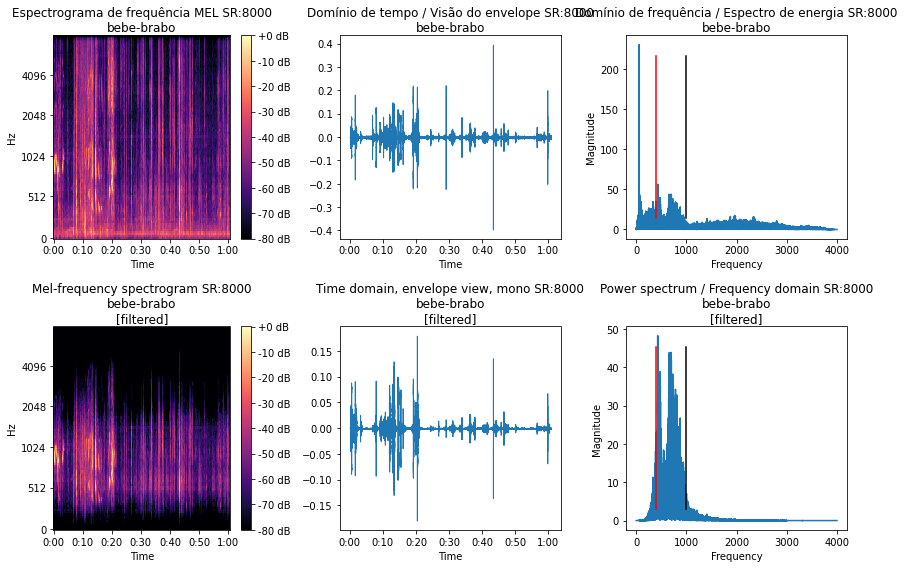

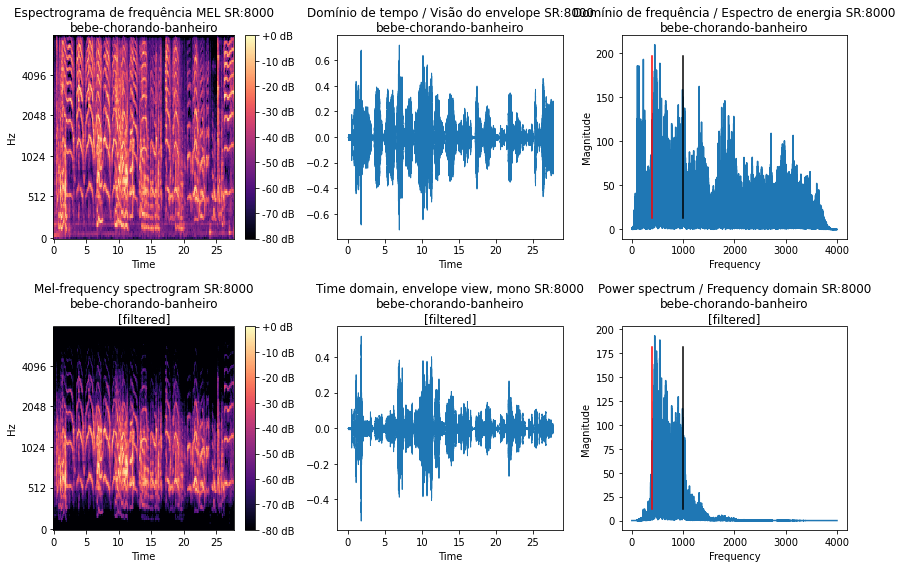

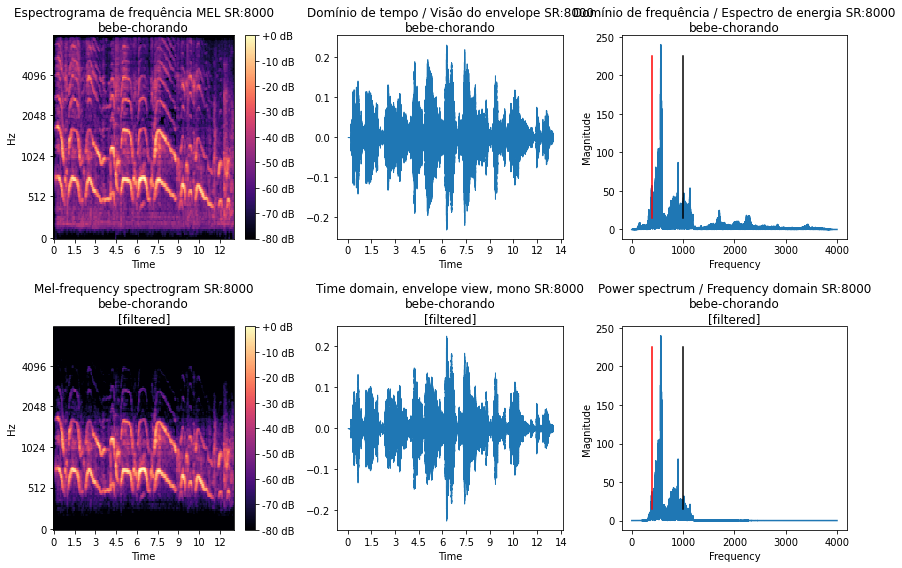

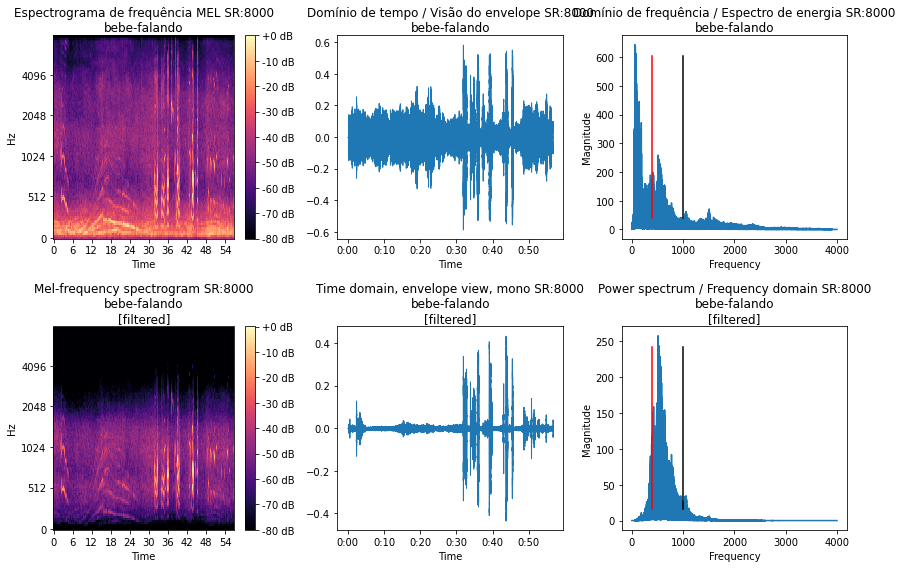

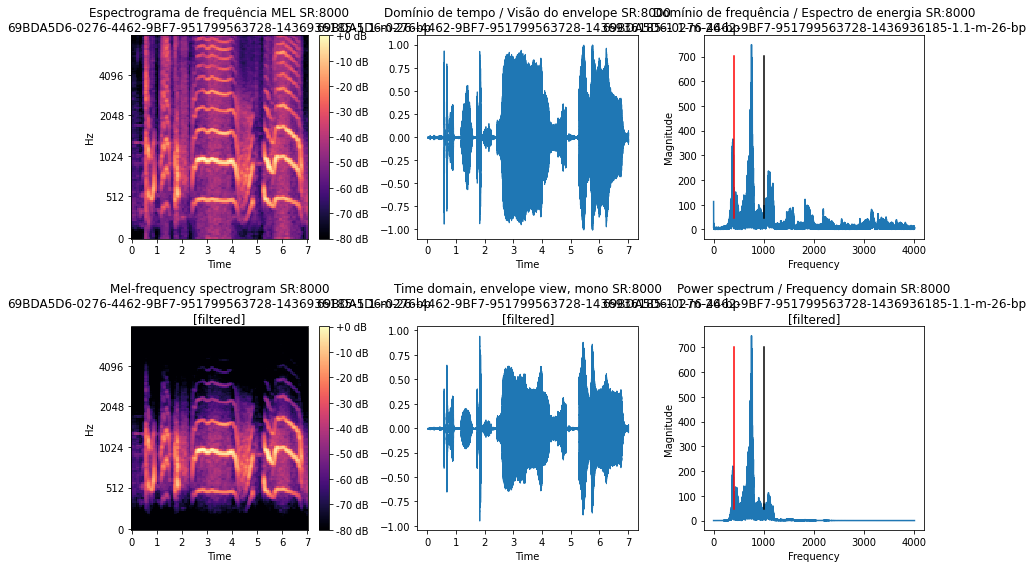

In [12]:
for example in examples:
    show_spectogram(example, default_filter)

show_spectogram("E:\\Source\\cryingbaby\\teste-filtro-audio\\donateacry-corpus\\donateacry_corpus_cleaned_and_updated_data\\belly_pain\\69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp.wav", \
    default_filter)


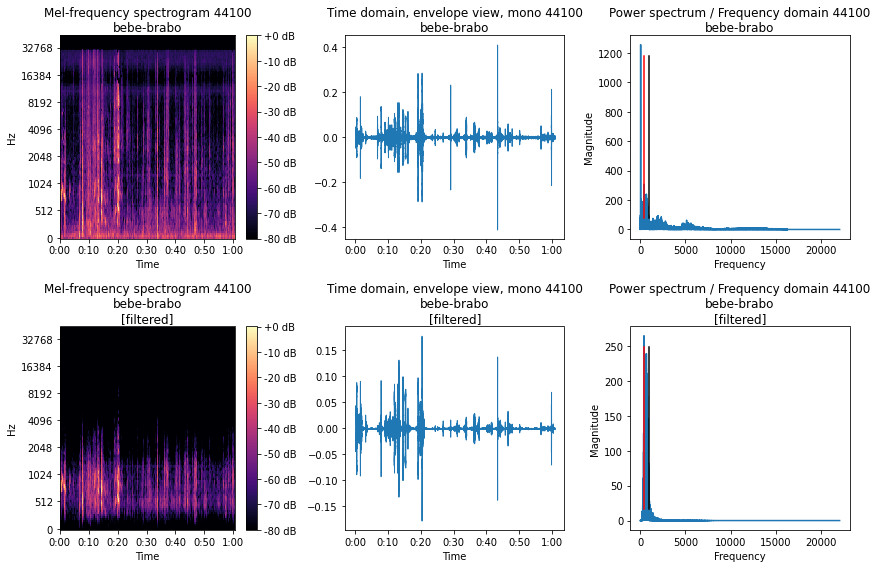

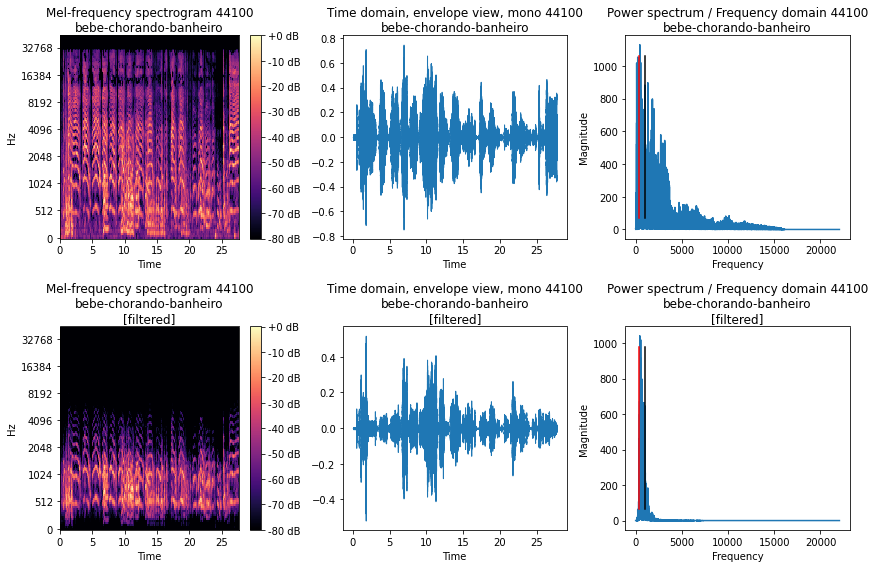

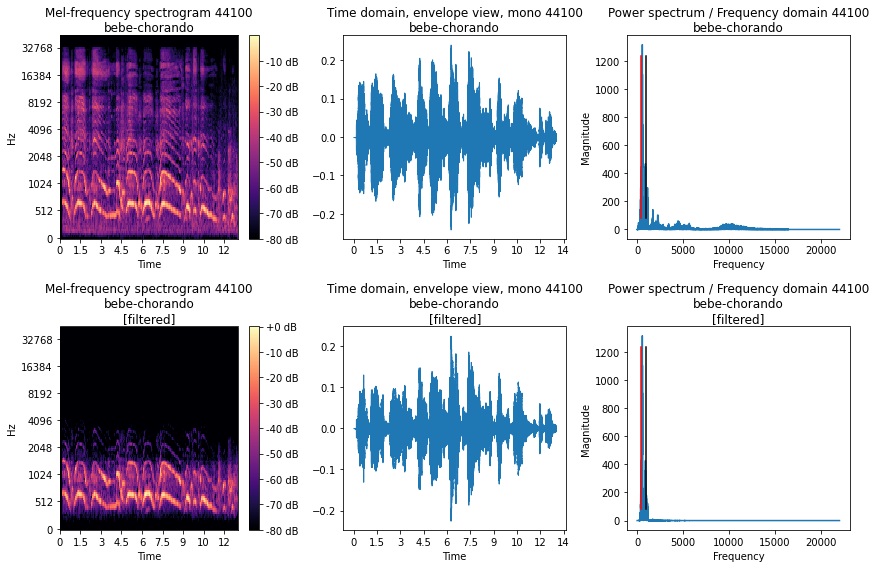

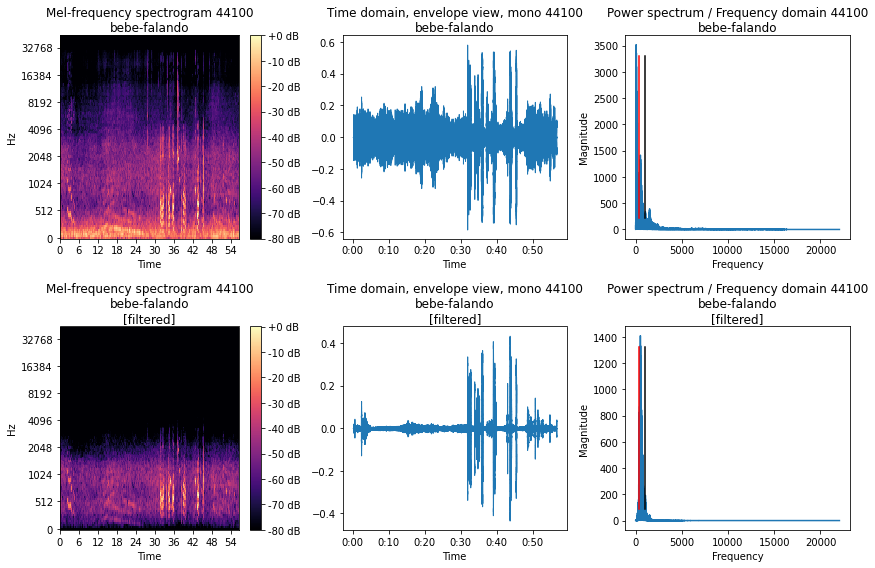

In [10]:
# Mostra nos exemplos SR=44100

for example in examples:
    show_spectogram(example, default_filter, sr=44100)

